# Colorectal Cancer Classification

## 1. Importing Libraries

In [7]:
import os
from os.path import isfile, join
from os import listdir
import time
import shutil
import pathlib
import itertools
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from sklearn.metrics import f1_score

print ('modules loaded')

modules loaded


## 2. Importing the Dataset

In [8]:
data_dir = 'C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-CRC-HE-100K'
sub_dir =os.listdir(data_dir)
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [9]:
df

filepaths labels
0      C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    ADI
1      C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    ADI
2      C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    ADI
3      C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    ADI
4      C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    ADI
...                                                  ...    ...
99995  C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    TUM
99996  C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    TUM
99997  C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    TUM
99998  C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    TUM
99999  C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-C...    TUM

[100000 rows x 2 columns]

## 3. Data Visualization

### 3.1 Distribution of the Labels

Distribution of Labels is as followed:
NORM     8763
MUC      8896
ADI     10407
STR     10446
BACK    10566
DEB     11512
LYM     11557
MUS     13536
TUM     14317
Name: labels, dtype: int64 
 



Text(0.5, 0.98, 'Distribution of Labels')

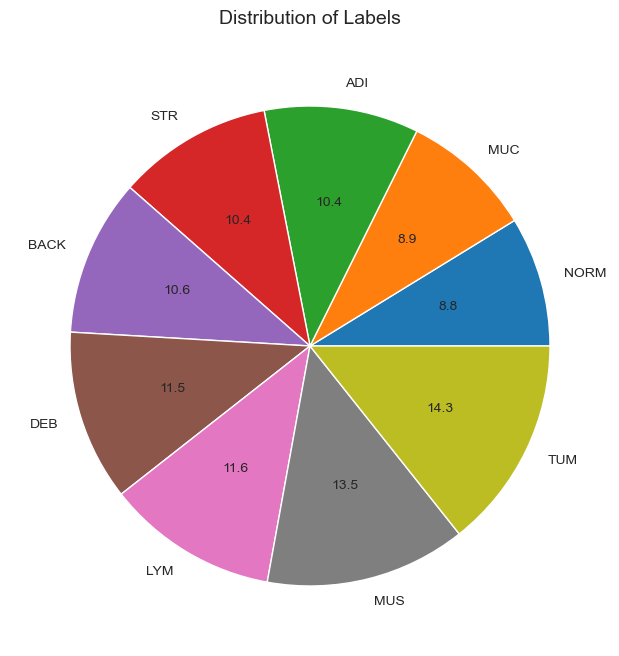

In [10]:
# Distribution of the Labels
labels_of_patch = df['labels'].value_counts()
print('Distribution of Labels is as followed:\n{}'.format(labels_of_patch[::-1]),'\n','\n')
                   
pie_fig = plt.figure(figsize=(6,7))
pie_axis = pie_fig.add_axes([0,0,1,1])
pie_axis.pie(labels_of_patch[::-1],labels=['NORM','MUC','ADI','STR','BACK','DEB','LYM','MUS','TUM'],startangle=0,autopct='%1.1f')
pie_fig.suptitle('Distribution of Labels',size=14)

### 3.2 Color Distribution of 3 Sample Images

Color Distribution for TUM - C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-CRC-HE-100K\TUM\TUM-HFMNQDEI.tif


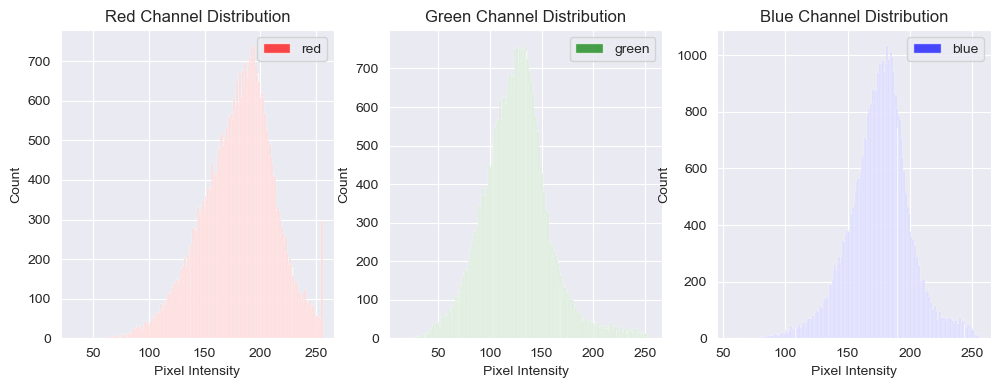

Color Distribution for MUS - C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-CRC-HE-100K\MUS\MUS-AVCLWCGW.tif


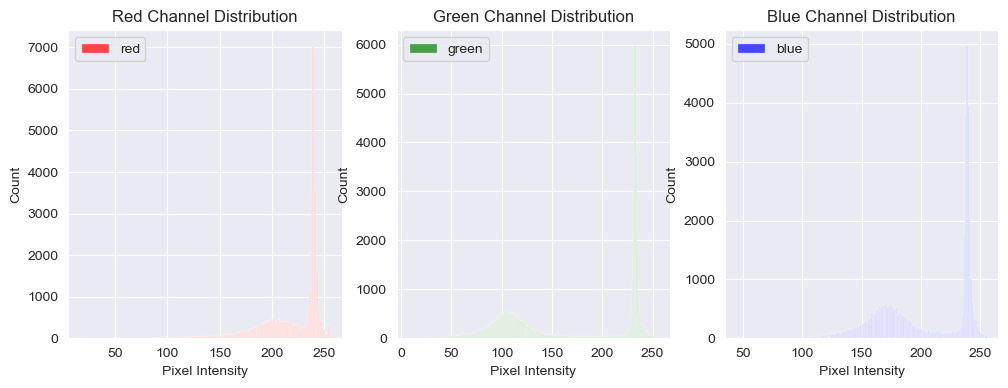

Color Distribution for MUC - C:/Users/benny/Downloads/NCT-CRC-HE-100K/NCT-CRC-HE-100K\MUC\MUC-PWVSWSQP.tif


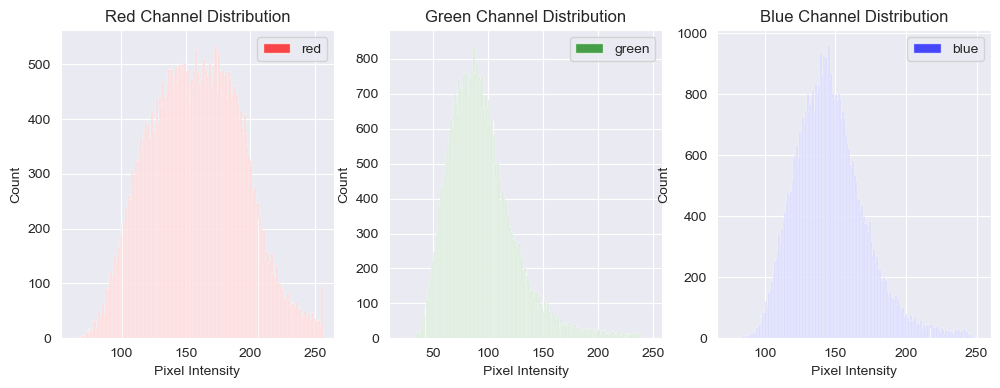

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

def plot_color_distribution(image_path):
    image = plt.imread(image_path)
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(12, 4))
    for i, color in enumerate(colors):
        plt.subplot(1, 3, i + 1)
        plt.hist(image[:, :, i].flatten(), bins=256, color=color, alpha=0.7, label=color)
        plt.title(f'{color.capitalize()} Channel Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Count')
        plt.legend()
    plt.show()

# Display color distribution for a random sample of images
sample_images = df.sample(3)
for index, row in sample_images.iterrows():
    print(f"Color Distribution for {row['labels']} - {row['filepaths']}")
    plot_color_distribution(row['filepaths'])


### 3.3 Feature Visualization Using VGG16 Model

29/29 [==============================] - 35s 1s/step


C:\Users\benny\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\benny\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


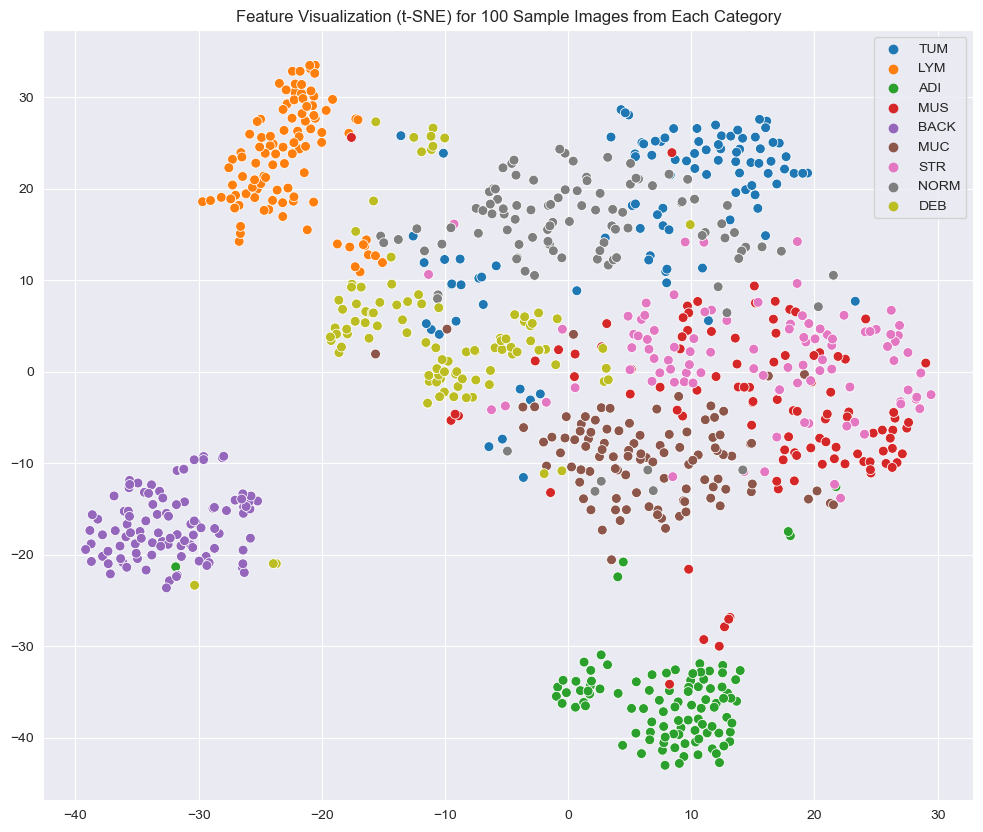

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
from sklearn.manifold import TSNE

# load and preprocess images using VGG16 model
def load_and_preprocess_images(image_paths):
    images = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.vstack(images)

# visualize intermediate features using VGG16 model
def visualize_features(image_paths, labels, sample_size=100):  # Adjust sample_size as needed
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

    sampled_images = []
    sampled_labels = []
    for label in set(labels):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        sampled_indices = label_indices[:sample_size]
        sampled_images.extend([image_paths[i] for i in sampled_indices])
        sampled_labels.extend([labels[i] for i in sampled_indices])

    X = load_and_preprocess_images(sampled_images)
    features = base_model.predict(X)

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=sampled_labels, palette='tab10', s=50)
    plt.title(f'Feature Visualization (t-SNE) for {sample_size} Sample Images from Each Category')
    plt.legend(loc='upper right')
    plt.show()

    
image_paths = df['filepaths'].tolist()
labels = df['labels'].tolist()
visualize_features(image_paths, labels, sample_size=100)


## 4. Splitting the Dataset

In [13]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

Class Distribution of Training Examples:
TUM     11453
MUS     10829
LYM      9246
DEB      9209
BACK     8453
STR      8357
ADI      8326
MUC      7117
NORM     7010
Name: labels, dtype: int64 
 
 
 

Class Distribution of Validation Examples:
TUM     1432
MUS     1353
LYM     1156
DEB     1151
BACK    1057
STR     1045
ADI     1041
MUC      889
NORM     876
Name: labels, dtype: int64 
 
 
 

Class Distribution of Test Examples:
TUM     1432
MUS     1354
LYM     1155
DEB     1152
BACK    1056
STR     1044
ADI     1040
MUC      890
NORM     877
Name: labels, dtype: int64 
 
 
 



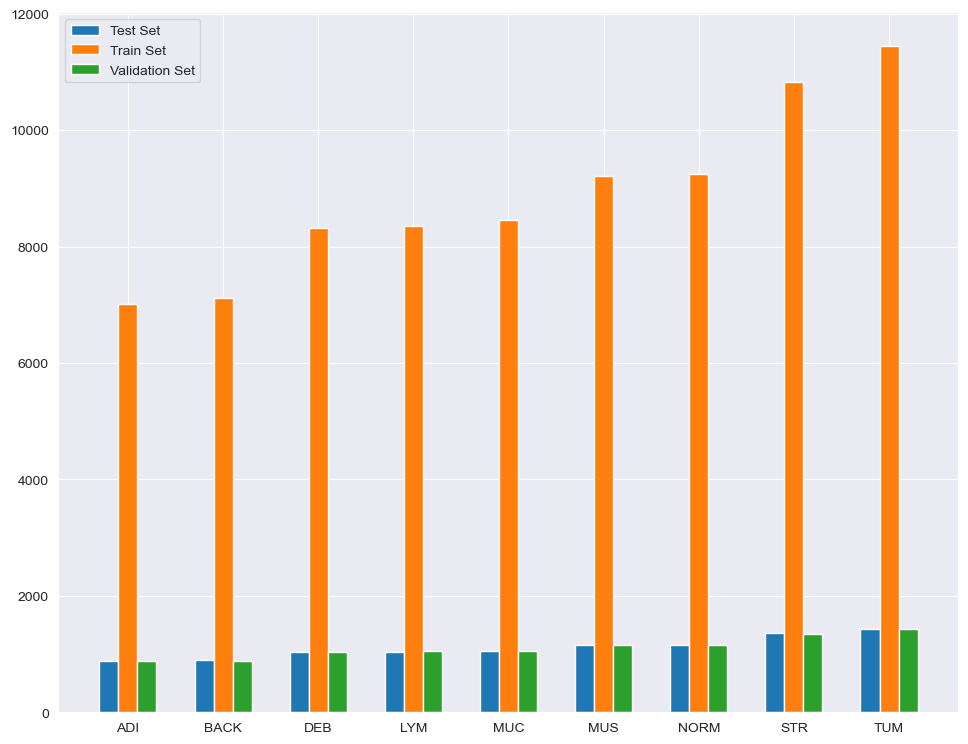

In [24]:
#check the distribution of data in training and validation sets
class_of_train_patch = train_df.labels.value_counts()
class_of_val_patch = valid_df.labels.value_counts()
class_of_test_patch = test_df.labels.value_counts()

print('Class Distribution of Training Examples:\n{}'.format(class_of_train_patch),'\n','\n','\n','\n')
print('Class Distribution of Validation Examples:\n{}'.format(class_of_val_patch),'\n','\n','\n','\n')
print('Class Distribution of Test Examples:\n{}'.format(class_of_test_patch),'\n','\n','\n','\n')

bar_fig = plt.figure(figsize=(9, 7))
bar_axis = bar_fig.add_axes([0, 0, 1, 1])

# Adjust x-values to prevent overlap
bar_width = 0.2
bar_axis.bar(np.arange(len(sub_dir)), class_of_test_patch[::-1], width=bar_width, label='Test Set')
bar_axis.bar(np.arange(len(sub_dir)) + bar_width, class_of_train_patch[::-1], width=bar_width, label='Train Set')
bar_axis.bar(np.arange(len(sub_dir)) + 2 * bar_width, class_of_val_patch[::-1], width=bar_width, label='Validation Set')

bar_axis.legend()
bar_axis.set_xticks(np.arange(len(sub_dir)) + bar_width)
bar_axis.set_xticklabels(sub_dir)
plt.show()


In [25]:
# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 80000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.
Found 10000 validated image filenames belonging to 9 classes.


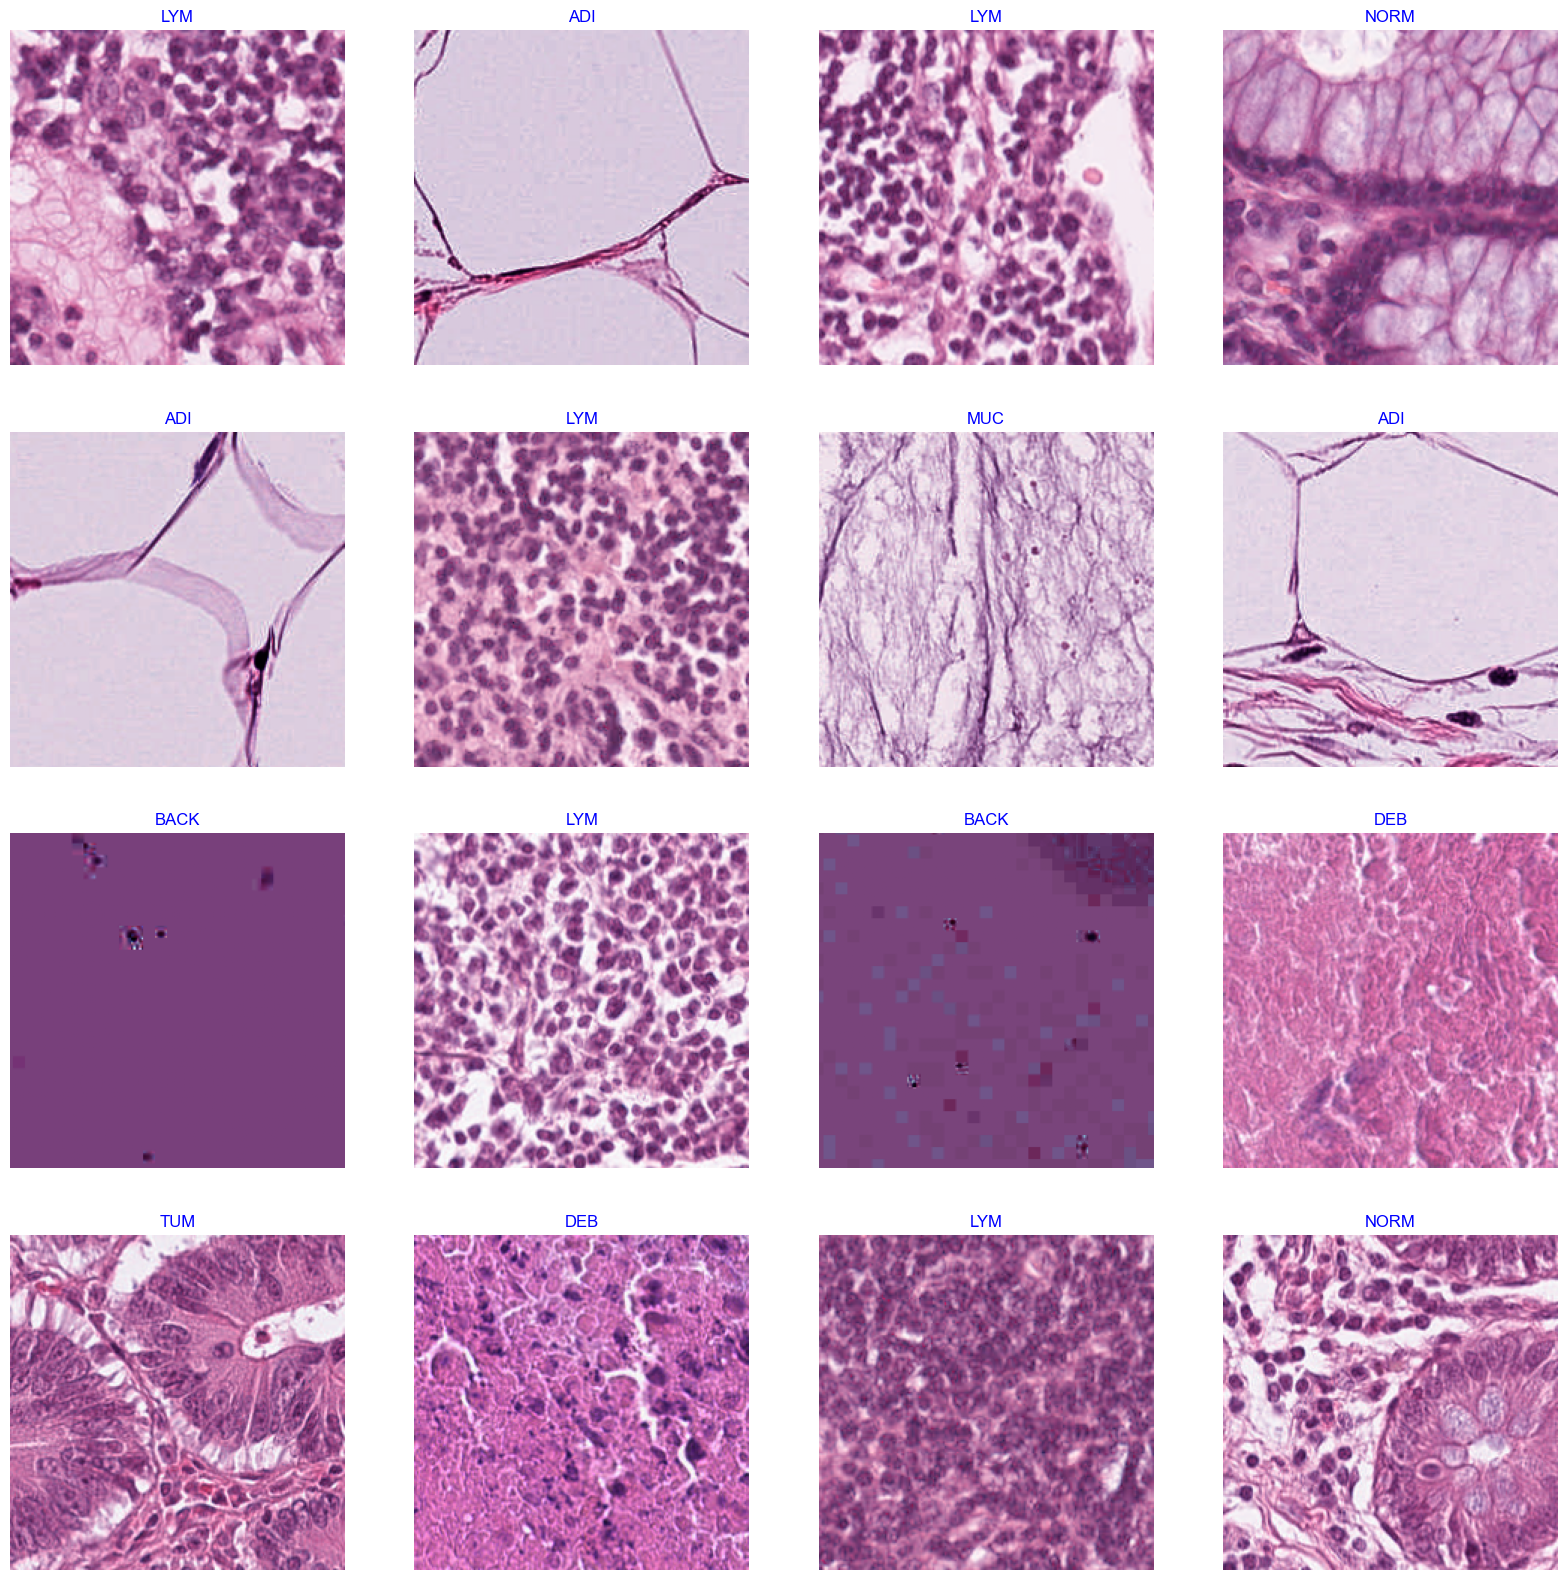

In [26]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get imageindex
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

## 5. Training the Model

In [27]:
# Create a function to calculate the F1 score metric
def F1_score(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

  return f1_val

In [28]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy', F1_score])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 29048576 (110.81 MB)
Trainable params: 5

In [29]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, shuffle= False,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)]
                    )

Epoch 1/10
625/625 [==============================] - 3772s 6s/step - loss: 3.3623 - accuracy: 0.8242 - F1_score: 0.8087 - val_loss: 1.1057 - val_accuracy: 0.8864 - val_F1_score: 0.8793
Epoch 2/10
625/625 [==============================] - 3623s 6s/step - loss: 0.9051 - accuracy: 0.8629 - F1_score: 0.8503 - val_loss: 0.7096 - val_accuracy: 0.8882 - val_F1_score: 0.8802
Epoch 3/10
625/625 [==============================] - 3709s 6s/step - loss: 0.7481 - accuracy: 0.8649 - F1_score: 0.8551 - val_loss: 0.6443 - val_accuracy: 0.8909 - val_F1_score: 0.8855
Epoch 4/10
625/625 [==============================] - 3617s 6s/step - loss: 0.7051 - accuracy: 0.8663 - F1_score: 0.8573 - val_loss: 0.6036 - val_accuracy: 0.8952 - val_F1_score: 0.8926
Epoch 5/10
625/625 [==============================] - 3614s 6s/step - loss: 0.6815 - accuracy: 0.8673 - F1_score: 0.8592 - val_loss: 0.5867 - val_accuracy: 0.8977 - val_F1_score: 0.8939
Epoch 6/10
625/625 [==============================] - 3622s 6s/step - 

## 6. Evaluation

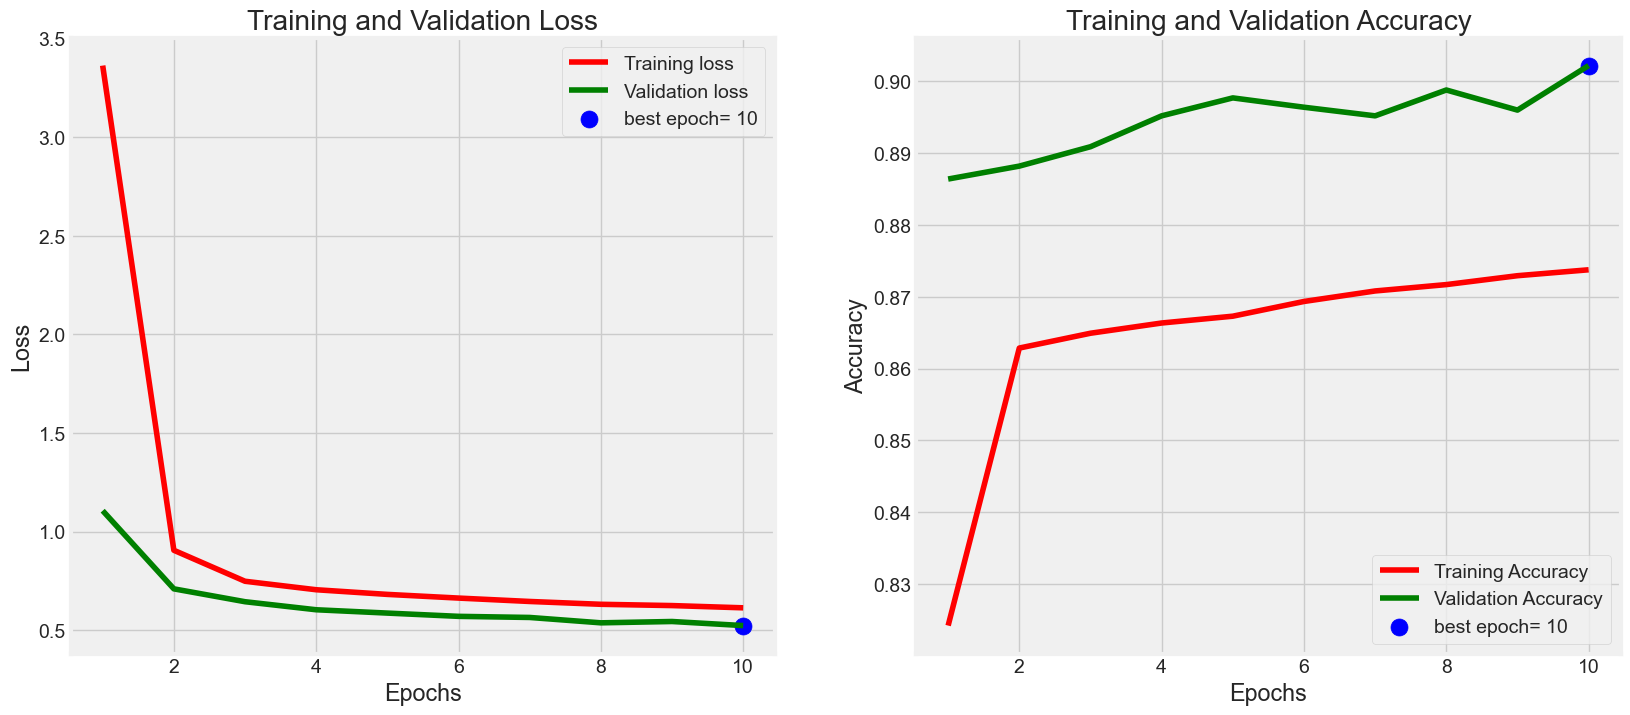

In [30]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [31]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

125/125 [==============================] - 392s 3s/step - loss: 0.5234 - accuracy: 0.9022 - F1_score: 0.9028
Train Loss:  0.5040329098701477
Train Accuracy:  0.9095625281333923
--------------------
Valid Loss:  0.5219358801841736
Valid Accuracy:  0.9021999835968018
--------------------
Test Loss:  0.523360013961792
Test Accuracy:  0.9021999835968018


## 7. Prediction

In [32]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

C:\Users\benny\AppData\Local\Temp\ipykernel_17952\2815406075.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


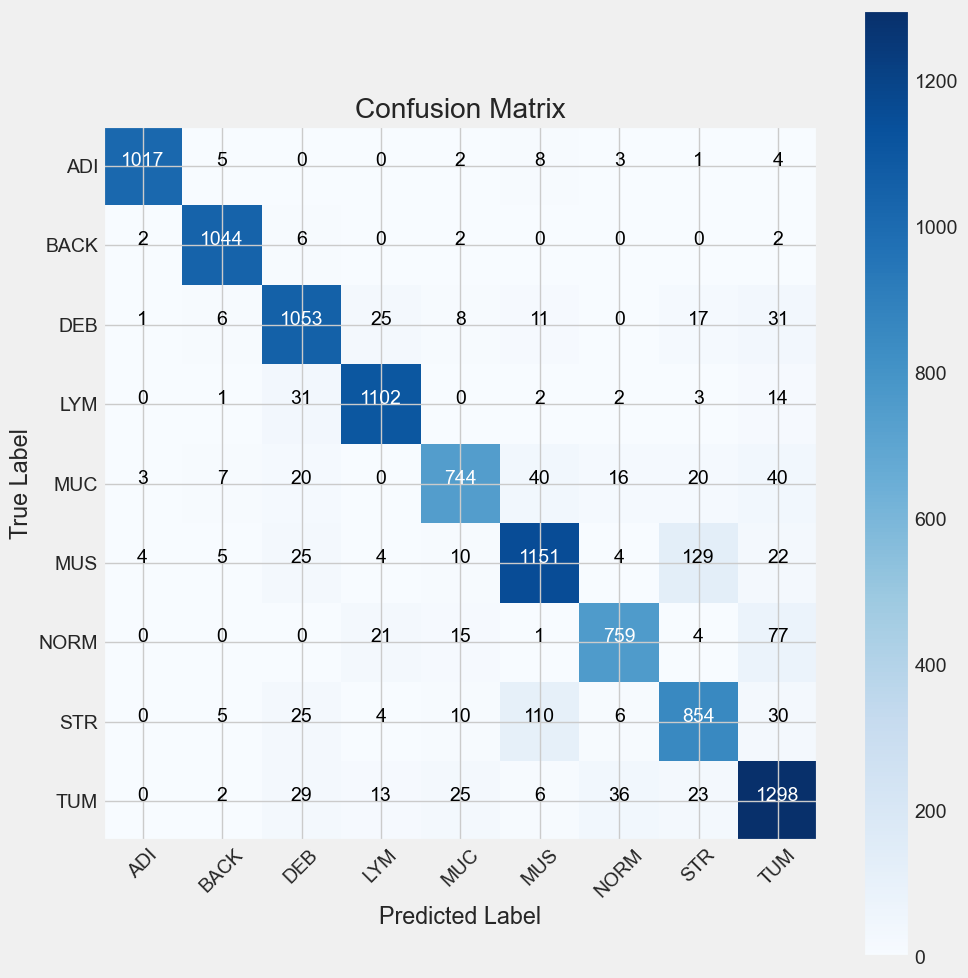

In [33]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [34]:
#Save the model
model.save('C:/Users/benny/Downloads/NCT-CRC-HE-100K/Model.h5')

C:\Users\benny\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
